# Transfer Learning

## Import packages

In [1]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 Load the CIFAR10 dataset (contained in Keras’s datasets) and train a deeper CNN with the following configuration:

- Input: 32 x 32 x 1
- CNN: kernal 3x3, 32 filters, ReLU Activation
- CNN: kernal 3x3, 32 filters, ReLU Activation
- Max Pool: 2x2
- CNN: kernal 3x3, 64 filters, ReLU Activation
- CNN: kernal 3x3, 64 filters, ReLU Activation
- Max Pool: 2x2
- Dropout: 0.25
- Flatten
- Dense: 512
- Dropout: 0.5
- Dense: 10

In [2]:
model = Sequential(name="cifar10")
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [3]:
model.summary()

Model: "cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1849

In [4]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [6]:

# initial cifar image shape
print(tf.shape(train_images))
print(tf.shape(test_images))
print(tf.shape(train_labels))
print(tf.shape(test_labels))

tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([10000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000     1], shape=(2,), dtype=int32)
tf.Tensor([10000     1], shape=(2,), dtype=int32)


In [7]:
# initial cifar image shape
print(tf.shape(train_labels))

tf.Tensor([50000     1], shape=(2,), dtype=int32)


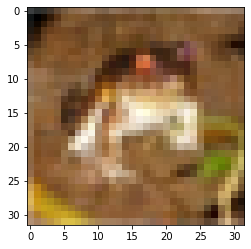

In [8]:
plt.imshow(train_images[0])

In [9]:
x_train = train_images / 255
x_test = test_images / 255

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

y_train = to_categorical(train_labels, NUM_CLASSES)
y_test = to_categorical(test_labels, NUM_CLASSES)


In [10]:


print(tf.shape(x_train))
print(tf.shape(y_train))



tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000    10], shape=(2,), dtype=int32)


## 1.2 Train this CNN for 10 epochs or more using a batch size of 32

In [11]:

epochs = 15
batch_size = 32

with tf.device('/device:GPU:0'):
    model.fit(x_train,
              y_train,
              validation_data=(x_test, y_test),
              epochs=epochs,
              batch_size=batch_size,
              shuffle=True)

Epoch 1/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5297 - accuracy: 0.4399 - val_loss: 1.1587 - val_accuracy: 0.5915
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1431 - accuracy: 0.5955 - val_loss: 0.9446 - val_accuracy: 0.6661
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9806 - accuracy: 0.6551 - val_loss: 0.8854 - val_accuracy: 0.6826
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8940 - accuracy: 0.6875 - val_loss: 0.8045 - val_accuracy: 0.7209
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8326 - accuracy: 0.7072 - val_loss: 0.8002 - val_accuracy: 0.7233
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7814 - accuracy: 0.7249 - val_loss: 0.7185 - val_accuracy: 0.7509
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7425 - accuracy: 0.7393 - val_loss: 0.7395 - val_accuracy:

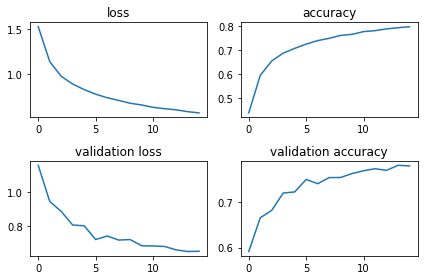

In [12]:

history = model.history.history

fig = plt.figure()

loss = fig.add_subplot(221)
loss.set_title('loss')
loss.plot(history['loss'])

accuracy = fig.add_subplot(222)
accuracy.set_title('accuracy')
accuracy.plot(history['accuracy'])

val_loss = fig.add_subplot(223)
val_loss.set_title('validation loss')
val_loss.plot(history['val_loss'])

val_accuracy = fig.add_subplot(224)
val_accuracy.set_title('validation accuracy')
val_accuracy.plot(history['val_accuracy'])

plt.tight_layout()
plt.show(fig)

In [13]:
model.save('train_cifar10.h5')

## 1.3 Evaluate the model's perfomance